# Phase 1: Real-World Small Cohort Analysis ($n=22$)
## Method: Agglomerative Hierarchical Clustering

**Associated Paper:** *An Unsupervised Decision-Support Framework for Multivariate Biomarker Analysis in Athlete Monitoring*

### 🎯 Objective
To identify latent physiological profiles in a real-world cohort of **22 amateur athletes**, monitored over a competitive microcycle (Pre-match, Post-match, 24h Recovery).

### ⚙️ Methodology (Why Hierarchical?)
As discussed in **Section 3.3** of the paper, standard algorithms like K-Means are unstable on small datasets ($n < 30$) due to stochastic initialization and sensitivity to outliers.
Therefore, we employ **Agglomerative Hierarchical Clustering (Ward's Linkage)**.
* **Ward's Method:** Minimizes within-cluster variance, producing compact and spherical clusters suitable for biological profiling.
* **Deterministic:** Unlike K-Means, it produces the same structure every time, ensuring reproducibility in small-sample studies.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Scikit-learn & Scipy for Hierarchical Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Configuration
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 6]
warnings.filterwarnings('ignore') # Keeps the notebook clean

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [14]:
# --- 1. DATA LOADING ---
# SECURITY NOTE: We use the synthetic seed file to ensure privacy compliance.
# The structure mirrors the real-world dataset used in the study.
filename = '../database/dataset_real_world_example.csv'

try:
    df = pd.read_csv(filename)
    print(f"Dataset '{filename}' loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: '{filename}' not found. Please run 'generate_real_world_seed.py' first.")

# --- 2. DATA CLEANING & UNIT CONVERSION ---

# 2.1 Handling European format (comma as decimal)
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['Nome', 'Posicao']:
        df[col] = df[col].str.replace(',', '.').astype(float, errors='ignore')

# 2.2 Blood Pressure Handling (Robustness Check)
# Synthetic data has 'Pressão' as float (Systolic). Real data might be '120/80'.
if 'Pressão (mmHG)' in df.columns:
    if df['Pressão (mmHG)'].dtype == 'object':
        # Logic for Real Data (Split 120/80)
        temp = df['Pressão (mmHG)'].str.split('/', expand=True)
        df['BP_Systolic (mmHg)'] = pd.to_numeric(temp[0])
        # We focus on Systolic for this analysis model
        df = df.drop(columns=['Pressão (mmHG)'])
    else:
        # Logic for Synthetic Data (Already Numeric)
        df = df.rename(columns={'Pressão (mmHG)': 'BP_Systolic (mmHg)'})

# 2.3 Testosterone Unit Conversion (nmol/L -> ng/dL)
# Factor: 1 nmol/L = 28.85 ng/dL
conversion_factor = 28.85
testo_cols = [c for c in df.columns if 'Testosterona' in c and 'nmol/L' in c]

for col in testo_cols:
    df[col] = df[col] * conversion_factor
    print(f"Converted units for: {col}")

# --- 3. TRANSLATION (PT -> EN) ---
# Mapping raw column names to the English terminology used in the paper
translation_map = {
    # Metadata
    'Nome': 'Name', 'Posicao': 'Position', 'Numero': 'Number',
    # Biomarkers
    'CPK Pré (U/L)': 'CK Pre (U/L)', 'CPK Pós (U/L)': 'CK Post (U/L)', 'CPK 24h (U/L)': 'CK 24h (U/L)',
    'LDH Pré (U/L)': 'LDH Pre (U/L)', 'LDH Pós (U/L)': 'LDH Post (U/L)', 'LDH 24h (U/L)': 'LDH 24h (U/L)',
    'PCR Pré (mg/L)': 'CRP Pre (mg/L)', 'PCR Pós (mg/L)': 'CRP Post (mg/L)', 'PCR 24h (mg/L)': 'CRP 24h (mg/L)',
    'Cortisol Pré (µg/dL)': 'Cortisol Pre (µg/dL)', 'Cortisol Pós (µg/dL)': 'Cortisol Post (µg/dL)', 'Cortisol 24h (µg/dL)': 'Cortisol 24h (µg/dL)',
    'Testosterona T Pré (nmol/L)': 'Testosterone Pre (ng/dL)', 
    'Testosterona T Pós (nmol/L)': 'Testosterone Post (ng/dL)', 
    'Testosterona 24h (nmol/L)': 'Testosterone 24h (ng/dL)',
    'FC Repouso (bpm)': 'Resting HR (bpm)', 
    'Oximetria (SpO2)': 'SpO2 (%)'
}

df_eng = df.rename(columns=translation_map)

print("-" * 30)
print("Data Translated and Cleaned.")
display(df_eng.filter(like='Testosterone').head(2))

Dataset '../database/dataset_real_world_example.csv' loaded. Shape: (22, 20)
Converted units for: Testosterona T Pré (nmol/L)
Converted units for: Testosterona T Pós (nmol/L)
Converted units for: Testosterona 24h (nmol/L)
------------------------------
Data Translated and Cleaned.


,Testosterone Pre (ng/dL),Testosterone Post (ng/dL),Testosterone 24h (ng/dL)
0,930.4125,678.552,977.1495
1,532.2825,748.369,820.7825


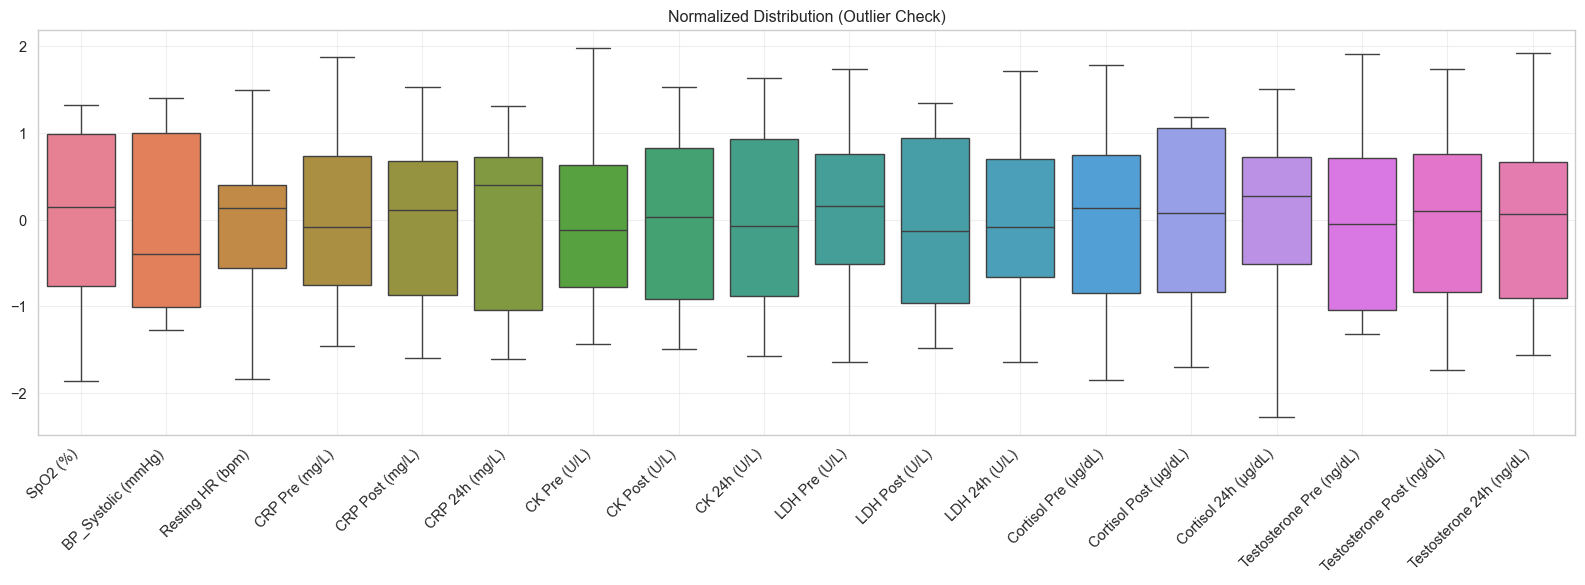

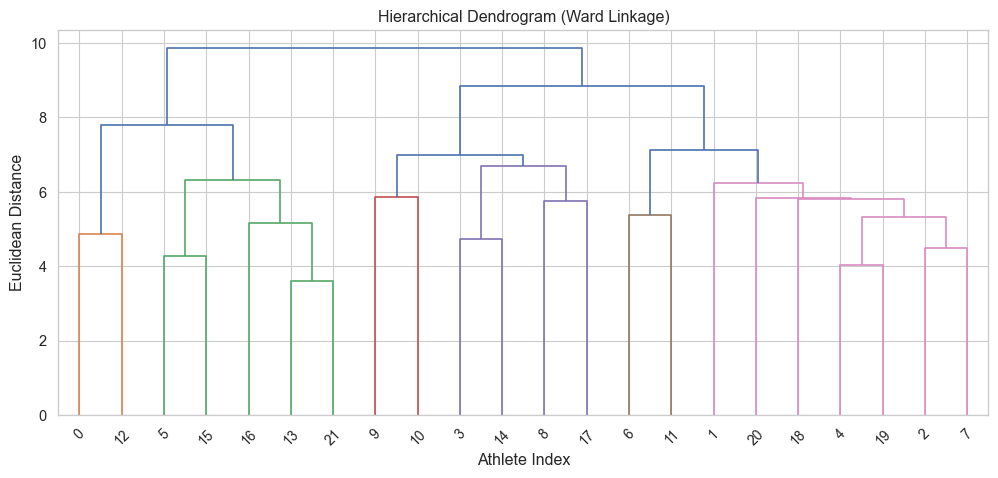

In [15]:
# --- 3. FEATURE SELECTION & SCALING ---

# Target Biomarkers (English Names)
feature_columns = [
    'SpO2 (%)', 'BP_Systolic (mmHg)', 'Resting HR (bpm)',
    'CRP Pre (mg/L)', 'CRP Post (mg/L)', 'CRP 24h (mg/L)',
    'CK Pre (U/L)', 'CK Post (U/L)', 'CK 24h (U/L)',
    'LDH Pre (U/L)', 'LDH Post (U/L)', 'LDH 24h (U/L)',
    'Cortisol Pre (µg/dL)', 'Cortisol Post (µg/dL)', 'Cortisol 24h (µg/dL)',
    'Testosterone Pre (ng/dL)', 'Testosterone Post (ng/dL)', 'Testosterone 24h (ng/dL)'
]

# Check availability
available_cols = [c for c in feature_columns if c in df_eng.columns]
if len(available_cols) < len(feature_columns):
    missing = set(feature_columns) - set(available_cols)
    print(f"Warning: Missing columns in dataset: {missing}")

# Create Numeric Matrix
df_numeric = df_eng[available_cols].copy()

# Handle NaNs (Median Imputation) and Zero Variance
df_numeric = df_numeric.fillna(df_numeric.median())
var_zero = df_numeric.columns[df_numeric.std() == 0]
if len(var_zero) > 0:
    print(f"Dropping constant columns: {list(var_zero)}")
    df_numeric = df_numeric.drop(columns=var_zero)

# Standardization (Z-Score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# --- VISUALIZATION ---

# 1. Outlier Check (Boxplot)
plt.figure(figsize=(16, 6))
sns.boxplot(data=pd.DataFrame(X_scaled, columns=df_numeric.columns))
plt.xticks(rotation=45, ha='right')
plt.title("Normalized Distribution (Outlier Check)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Hierarchical Dendrogram
plt.figure(figsize=(12, 5))
plt.title("Hierarchical Dendrogram (Ward Linkage)")
# Using Ward's method as defined in the paper for stability
dendro = dendrogram(linkage(X_scaled, method='ward'))
plt.ylabel('Euclidean Distance')
plt.xlabel('Athlete Index')
plt.show()


--- Analysis for k=3 Clusters ---
Silhouette Score (Separation Quality): 0.073


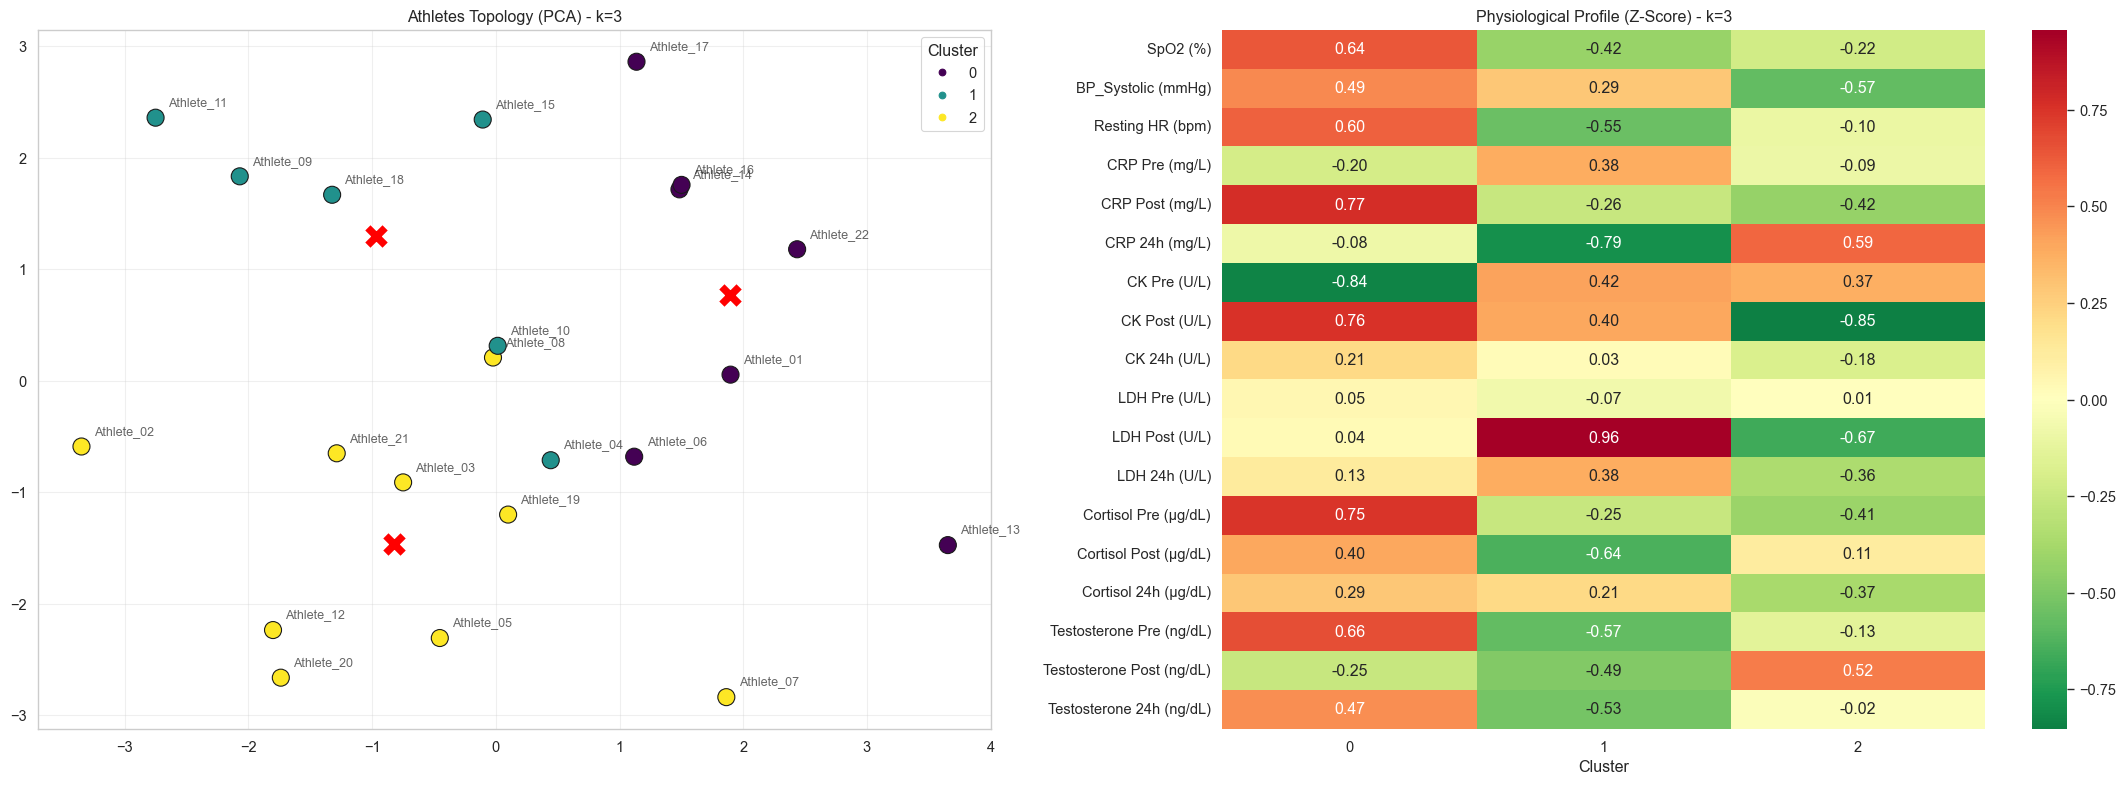


Sample Athletes in each Cluster (k=3):


,Name,Cluster_k3,Testosterone Pre (ng/dL),Cortisol Pre (µg/dL),CK Pre (U/L)
0,Athlete_01,0,930.4125,20.11,286.91
16,Athlete_17,0,843.8625,21.51,179.27
15,Athlete_16,0,665.2810,18.73,226.74
8,Athlete_09,1,495.0660,9.59,355.23
9,Athlete_10,1,714.6145,14.25,503.33
3,Athlete_04,1,356.2975,20.69,281.05
6,Athlete_07,2,624.3140,19.18,281.47
7,Athlete_08,2,679.9945,17.66,314.86
20,Athlete_21,2,325.7165,11.32,287.08



--- Analysis for k=5 Clusters ---
Silhouette Score (Separation Quality): 0.076


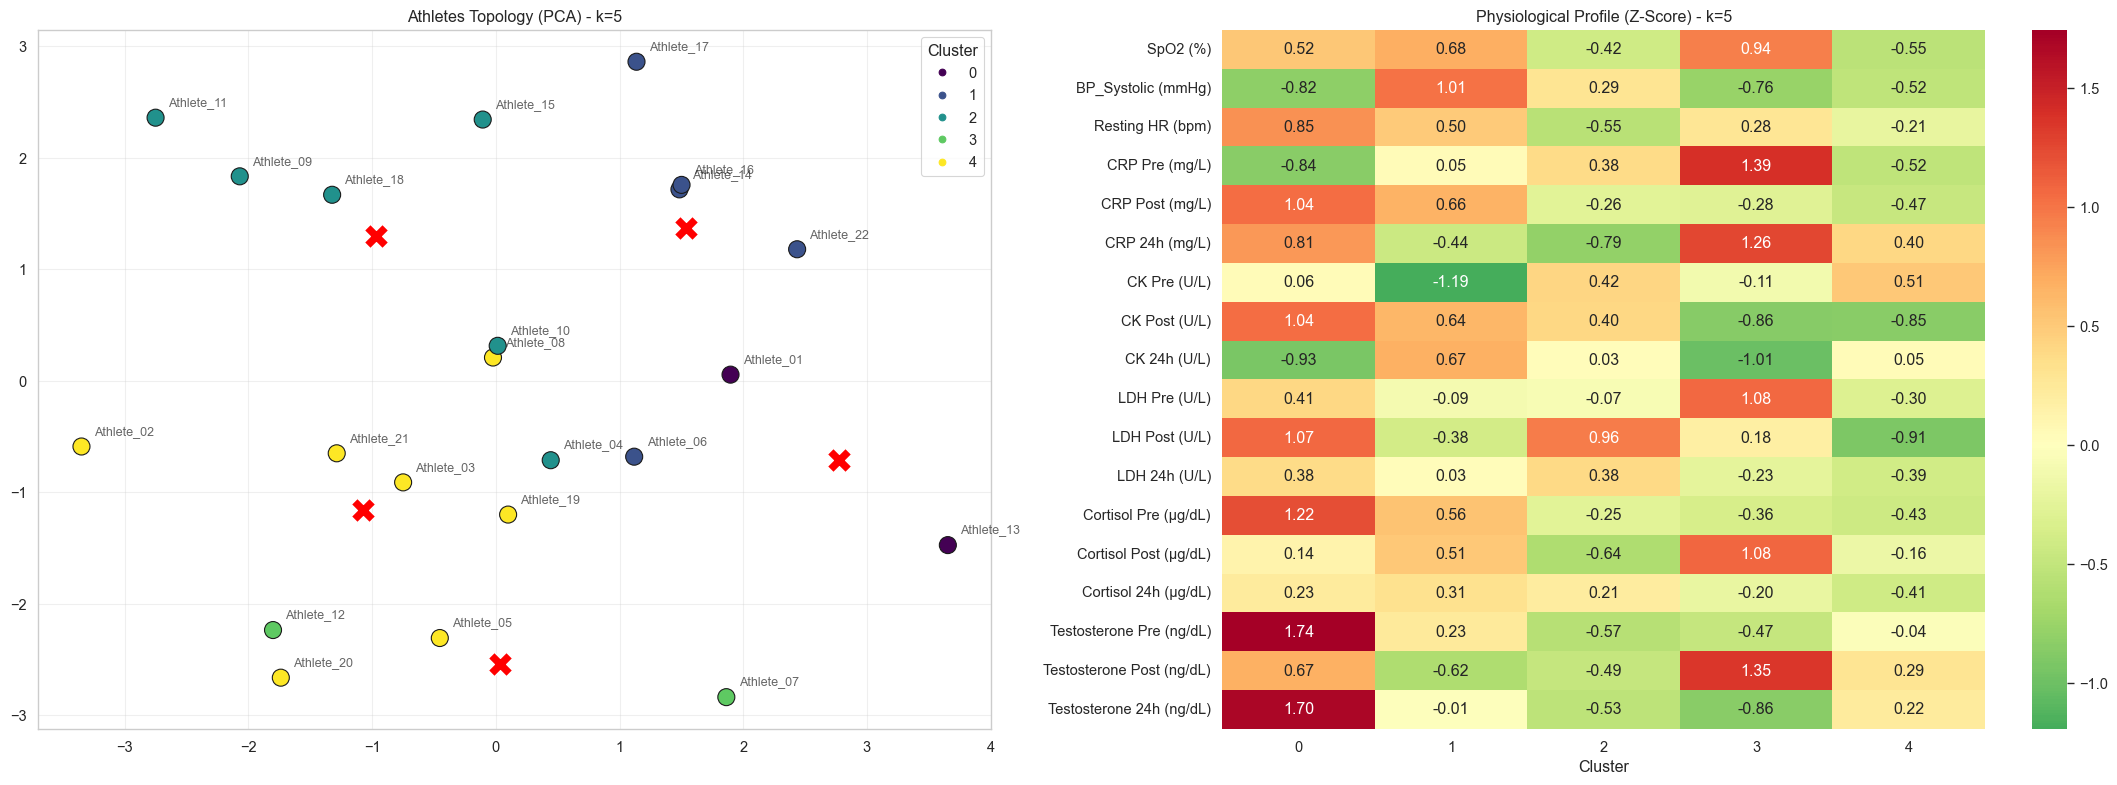


Sample Athletes in each Cluster (k=5):


,Name,Cluster_k5,Testosterone Pre (ng/dL),Cortisol Pre (µg/dL),CK Pre (U/L)
0,Athlete_01,0,930.4125,20.11,286.91
12,Athlete_13,0,881.9445,24.54,416.59
16,Athlete_17,1,843.8625,21.51,179.27
15,Athlete_16,1,665.2810,18.73,226.74
13,Athlete_14,1,548.1500,14.68,170.90
8,Athlete_09,2,495.0660,9.59,355.23
9,Athlete_10,2,714.6145,14.25,503.33
3,Athlete_04,2,356.2975,20.69,281.05
6,Athlete_07,3,624.3140,19.18,281.47
11,Athlete_12,3,315.3305,12.15,381.41


In [16]:
# --- 4. CLUSTERING EXPLORATION (k=3, k=5) ---

k_values = [3, 5]

for k in k_values:
    print(f"\n{'='*60}")
    print(f"--- Analysis for k={k} Clusters ---")
    print(f"{'='*60}")

    # Model: Agglomerative Clustering (Ward)
    model = linkage(X_scaled, method='ward')
    labels = fcluster(model, t=k, criterion='maxclust')
    
    # Adjust labels to start at 0
    labels = labels - 1
    
    col_cluster = f'Cluster_k{k}'
    df_eng[col_cluster] = labels

    # Silhouette Score
    sil = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score (Separation Quality): {sil:.3f}")

    # --- PLOTTING ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Plot A: PCA Projection
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=150, edgecolors='k')
    
    # Calculate Centroids for visualization
    centroids_pca = []
    for i in range(k):
        if np.sum(labels == i) > 0:
            centroids_pca.append(X_pca[labels == i].mean(axis=0))
    
    if centroids_pca:
        ax1.scatter(np.array(centroids_pca)[:, 0], np.array(centroids_pca)[:, 1], 
                   s=300, c='red', marker='X', label='Centroid', edgecolors='white')

    # Annotate Names (if few athletes)
    if 'Name' in df_eng.columns and len(df_eng) < 60:
        for i, txt in enumerate(df_eng['Name']):
            ax1.annotate(txt, (X_pca[i, 0]+0.1, X_pca[i, 1]+0.1), fontsize=9, alpha=0.7)

    ax1.set_title(f'Athletes Topology (PCA) - k={k}')
    ax1.legend(*scatter.legend_elements(), title="Cluster")
    ax1.grid(True, alpha=0.3)

    # Plot B: Physiological Heatmap (Z-Score)
    # Re-calculate Z-Scores for the heatmap relative to the groups
    df_vis = df_numeric.copy()
    df_vis['Cluster'] = labels
    avg_profile = df_vis.groupby('Cluster').mean()
    
    # Global Z-Score for visualization contrast
    viz_zscore = (avg_profile - df_numeric.mean()) / df_numeric.std()

    sns.heatmap(viz_zscore.T, ax=ax2, cmap='RdYlGn_r', center=0, annot=True, fmt='.2f')
    ax2.set_title(f'Physiological Profile (Z-Score) - k={k}')
    
    plt.tight_layout()
    plt.show()

    # Display Sample
    print(f"\nSample Athletes in each Cluster (k={k}):")
    cols_display = ['Name', col_cluster, 'Testosterone Pre (ng/dL)', 'Cortisol Pre (µg/dL)', 'CK Pre (U/L)']
    cols_display = [c for c in cols_display if c in df_eng.columns]
    
    display(df_eng[cols_display].sort_values(col_cluster).groupby(col_cluster).head(3))

NOTA: Só notei no mapa de dispersão os dois grandes outliers que existem nos dados (00023-0001 e 00024-0001). Eles devem ser retirados para clusterizarmos de novo.

Vamos remover os outliers e executar a clusterização novamente abaixo.

Flagged 2 subjects with highest deviation (Candidates for exclusion):


,Name,Euclidean_Dist,SpO2 (%),BP_Systolic (mmHg),Resting HR (bpm)
12,Athlete_13,5.002856,97.52,112.36,68.51
8,Athlete_09,5.010748,98.25,126.90,46.76



Outliers Removed. Cohort size: 22 -> 20


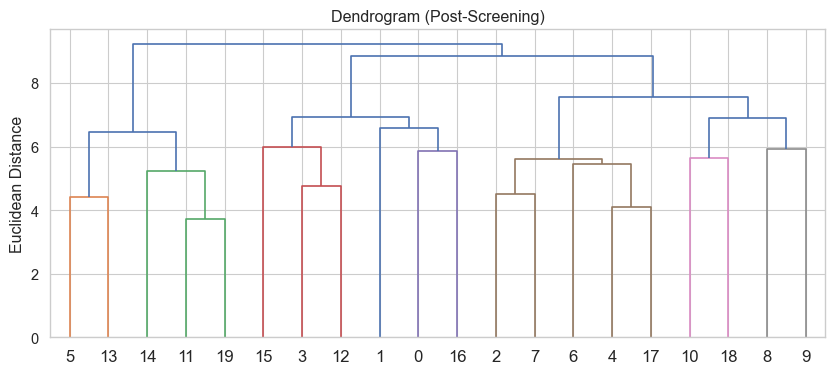


--- Final Model: Macro-Management (k=3) ---


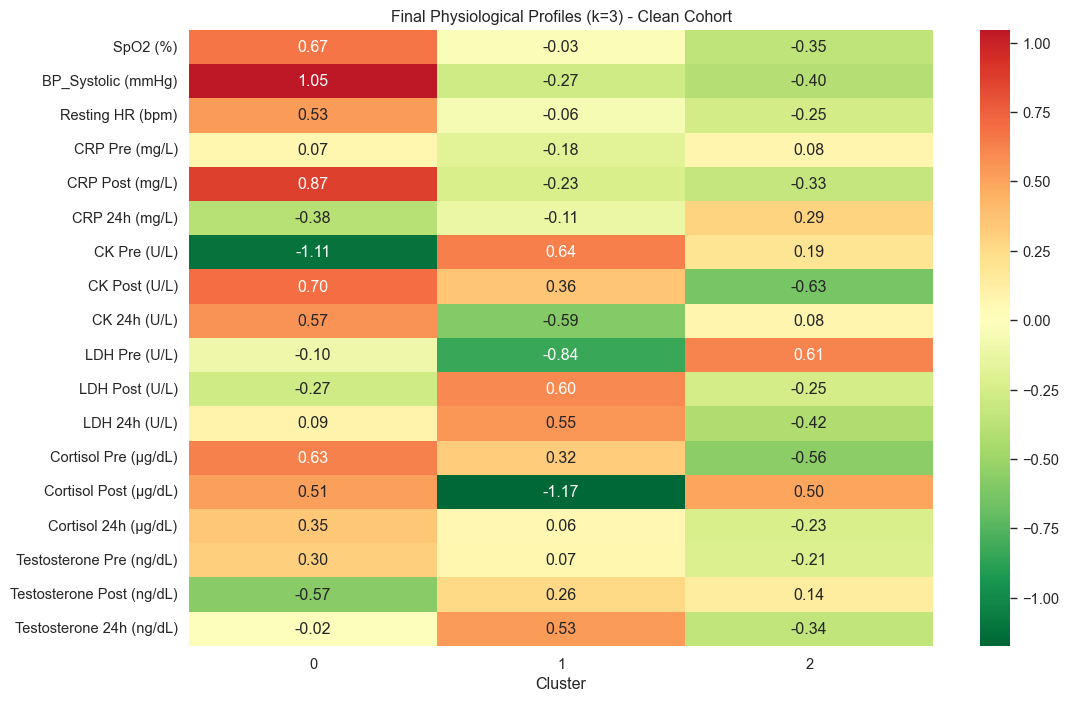

Cluster Characterization (Top Varying Features):


,Name,Cluster_Final,Testosterone Post (ng/dL),Testosterone Pre (ng/dL),Testosterone 24h (ng/dL)
0,Athlete_01,1,678.5520,930.4125,977.1495
1,Athlete_02,1,748.3690,532.2825,820.7825
2,Athlete_03,2,812.1275,559.4015,688.3610
4,Athlete_05,2,660.9535,705.6710,591.1365
5,Athlete_06,0,521.3195,314.4650,467.0815
13,Athlete_14,0,790.4900,548.1500,795.9715


In [ ]:
# --- 5. CLINICAL SAFETY SCREENING (Outlier Removal) ---
# As described in the paper, we calculate the Euclidean distance of each subject 
# to the global centroid to identify potential pathological outliers.

# Calculate Distances
global_centroid = np.mean(X_scaled, axis=0)
distances = np.linalg.norm(X_scaled - global_centroid, axis=1)
df_eng['Euclidean_Dist'] = distances

# Identify Top 2 Outliers (Simulating the paper's exclusion step)
n_outliers = 2
outlier_indices = np.argsort(distances)[-n_outliers:]
outlier_ids = df_eng.index[outlier_indices]

print(f"Flagged {n_outliers} subjects with highest deviation (Candidates for exclusion):")
cols_outlier_view = ['Name', 'Euclidean_Dist'] + list(df_numeric.columns[:3])
display(df_eng.loc[outlier_ids, cols_outlier_view])

# Remove Outliers
df_clean = df_eng.drop(index=outlier_ids).copy()
X_clean_raw = df_numeric.drop(index=outlier_ids)

print(f"\nOutliers Removed. Cohort size: {len(df_eng)} -> {len(df_clean)}")

# --- FINAL CLUSTERING ON CLEAN DATA ---
# Re-scale after removal
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_clean_raw)

# Final Dendrogram Check
plt.figure(figsize=(10, 4))
plt.title("Dendrogram (Post-Screening)")
dendrogram(linkage(X_final_scaled, method='ward'))
plt.ylabel('Euclidean Distance')
plt.show()

# Final k=3 Analysis (Macro-Management View)
k_final = 3
print(f"\n--- Final Model: Macro-Management (k={k_final}) ---")

model_final = linkage(X_final_scaled, method='ward')
labels_final = fcluster(model_final, t=k_final, criterion='maxclust') - 1

df_clean['Cluster_Final'] = labels_final

# Final Heatmap
fig, ax = plt.subplots(figsize=(12, 8))
df_vis_final = X_clean_raw.copy()
df_vis_final['Cluster'] = labels_final
avg_profile_final = df_vis_final.groupby('Cluster').mean()

# Z-Score relative to clean population
viz_zscore_final = (avg_profile_final - X_clean_raw.mean()) / X_clean_raw.std()

sns.heatmap(viz_zscore_final.T, ax=ax, cmap='RdYlGn_r', center=0, annot=True, fmt='.2f')
plt.title(f'Final Physiological Profiles (k={k_final}) - Clean Cohort')
plt.show()

# Summary Table
print("Cluster Characterization (Top Varying Features):")
top_vars = X_clean_raw.var().sort_values(ascending=False).head(3).index.tolist()
display(df_clean[['Name', 'Cluster_Final'] + top_vars].groupby('Cluster_Final').head(2))